In [2]:
import os

import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
sns.set()

In [4]:
DATA_DIR = "D:\\works\\store sales data\\sales_data_v2"

#### Read Files

In [5]:
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(DATA_DIR):
    for file in f:
        files.append(os.path.join(r, file))

In [6]:
dfs = [pd.read_csv(file) for file in files]

In [7]:
print([df.shape for df in dfs])

[(11584, 10), (2327, 10), (7921, 10), (9526, 10), (10049, 10), (16238, 10), (462, 10), (2503, 10), (2503, 10)]


In [8]:
[df["Store Code"].unique() for df in dfs]

[array(['Store 1'], dtype=object),
 array(['Store 2'], dtype=object),
 array(['Store 2'], dtype=object),
 array(['Store 3'], dtype=object),
 array(['Store 4'], dtype=object),
 array(['Store 5'], dtype=object),
 array(['Store 5'], dtype=object),
 array(['Store 6'], dtype=object),
 array(['Store 6'], dtype=object)]

#### Preprocess

In [9]:
# Concatenating data of same store
df_store_1 = dfs[0].drop_duplicates()
df_store_2 = dfs[1].append(dfs[2]).drop_duplicates()
df_store_3 = dfs[3].drop_duplicates()
df_store_4 = dfs[4].drop_duplicates()
df_store_5 = dfs[5].append(dfs[6]).drop_duplicates()
df_store_6 = dfs[7].append(dfs[8]).drop_duplicates()

In [10]:
dfs = [df_store_1, df_store_2, df_store_3, df_store_4, df_store_5, df_store_6]

In [11]:
[df["Store Code"].unique() for df in dfs]

[array(['Store 1'], dtype=object),
 array(['Store 2'], dtype=object),
 array(['Store 3'], dtype=object),
 array(['Store 4'], dtype=object),
 array(['Store 5'], dtype=object),
 array(['Store 6'], dtype=object)]

In [12]:
print([df.shape for df in dfs])

[(11163, 10), (9001, 10), (8790, 10), (9311, 10), (15247, 10), (2445, 10)]


In [13]:
def preprocess_data(df):
    # Keep rows where price > 0 
    df = df[df["Sales Price"] > 0]

    # Keep rows where MRP >= sell price
    df = df[df["MRP"] >= df["Sales Price"]]
    
    print('Number of missing values:\n',df.isnull().sum())
    df = df[~df["Category"].isnull()]
    
    # Remove returned items
    df = df[df["Sales Qty"]>0]

    df["Sale Date"] = pd.to_datetime(df["Sale Date"])
    return df

preprocessed_dfs = [preprocess_data(df) for df in dfs]

Number of missing values:
 SKU Code       0
Brand Code     0
Category       0
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP            0
Sales Price    0
Sales Qty      0
dtype: int64
Number of missing values:
 SKU Code       0
Brand Code     0
Category       0
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP            0
Sales Price    0
Sales Qty      0
dtype: int64
Number of missing values:
 SKU Code       0
Brand Code     8
Category       8
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP            0
Sales Price    0
Sales Qty      0
dtype: int64
Number of missing values:
 SKU Code       0
Brand Code     0
Category       0
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP            0
Sales Price    0
Sales Qty      0
dtype: int64
Number of missing values:
 SKU Code       0
Brand Code     0
Category       0
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP           

In [14]:
print([df.shape for df in preprocessed_dfs])

[(9610, 10), (7939, 10), (7895, 10), (8447, 10), (13359, 10), (2337, 10)]


In [15]:
#Sale Dates 
[df["Sale Date"].describe() for df in preprocessed_dfs]

[count                    9610
 unique                    278
 top       2017-07-29 00:00:00
 freq                      109
 first     2017-05-24 00:00:00
 last      2018-02-28 00:00:00
 Name: Sale Date, dtype: object, count                    7939
 unique                    365
 top       2017-12-30 00:00:00
 freq                       62
 first     2017-03-01 00:00:00
 last      2018-02-28 00:00:00
 Name: Sale Date, dtype: object, count                    7895
 unique                    176
 top       2017-09-30 00:00:00
 freq                      134
 first     2017-09-06 00:00:00
 last      2018-02-28 00:00:00
 Name: Sale Date, dtype: object, count                    8447
 unique                    188
 top       2017-09-09 00:00:00
 freq                      125
 first     2017-08-23 00:00:00
 last      2018-02-28 00:00:00
 Name: Sale Date, dtype: object, count                   13359
 unique                    422
 top       2017-11-04 00:00:00
 freq                      113
 fir

#### Features

In [16]:
def get_features(df):
    df["year"] = df["Sale Date"].dt.year
    df["week"] = df["Sale Date"].dt.week
    df["month"] = df["Sale Date"].dt.month
    df["Amount"] = df["Sales Price"] * df["Sales Qty"]
    df["discount"] = df.apply(lambda x: 100*(1 - (x["Sales Price"]/x["MRP"])),  axis=1)
    return df


In [17]:
features_dfs = [get_features(df) for df in preprocessed_dfs]

In [18]:
def create_plot(df, by):
    groupdf = df.groupby(by)["Sales Qty"].sum()
    groupdf = groupdf.reset_index()
  
    values = list(groupdf.loc[:, 'Sales Qty'])
        
    g = sns.FacetGrid(groupdf, col="year")
    g.map(plt.bar, "month", "Sales Qty")
    g.fig.suptitle(groupdf["Store Code"].unique()[0])

### Sales in quantity 

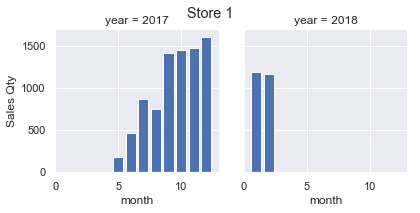

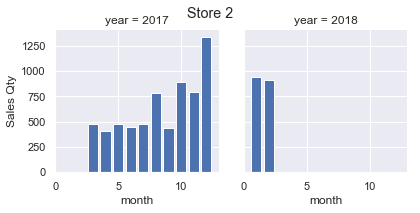

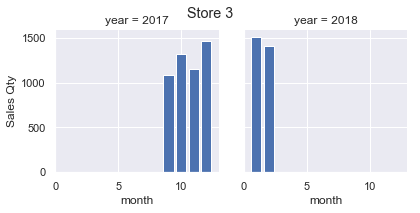

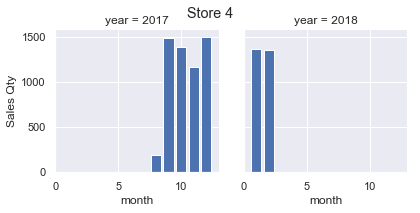

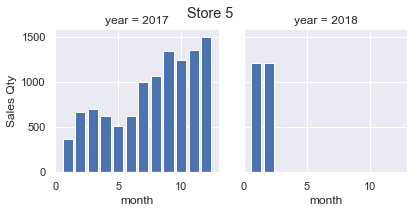

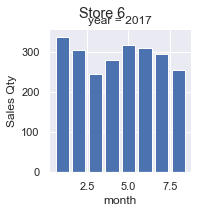

In [19]:
for df in features_dfs:
    create_plot(df, by=["year", "month", "Store Code"])

In [20]:
def category_monthly_stats(df):
    df["average_selling_price"] = np.sum(df["Amount"]) / np.sum(df["Sales Qty"])
    df["max_discount"] = df["discount"].max()
    return df


In [23]:
def nonzero_mode(arr):
    return stats.mode(arr[np.nonzero(arr)]).mode

def get_discount(df):
    arr = nonzero_mode(np.array(df["discount"]))
    if len(arr) > 0:
        return arr[0]
    return 0
#     return np.sum((df["discount"] * df["Sales Qty"]))/np.sum(df["Sales Qty"])

In [22]:
master_df = pd.concat(features_dfs)

In [24]:
stores = master_df["Store Code"].unique().tolist()
stores.sort()

In [ ]:
categories = master_df["Category"].unique().tolist()
categories.sort()

#### Sales Qty & Discount by Stores - Category

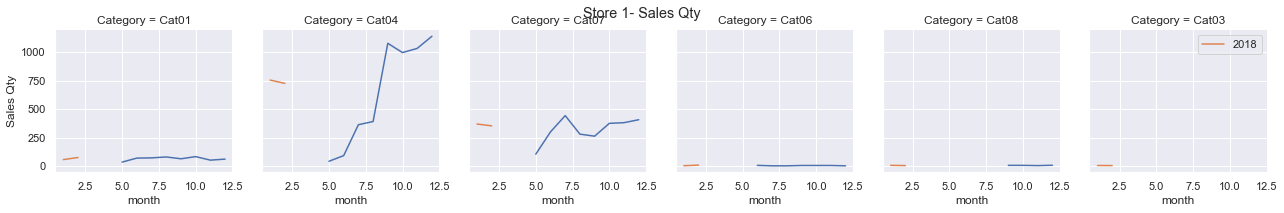

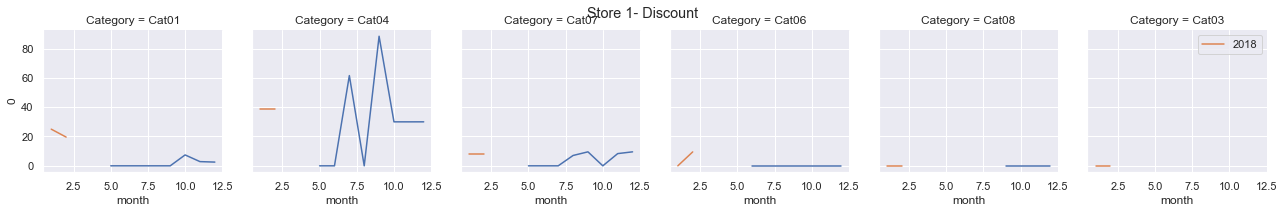

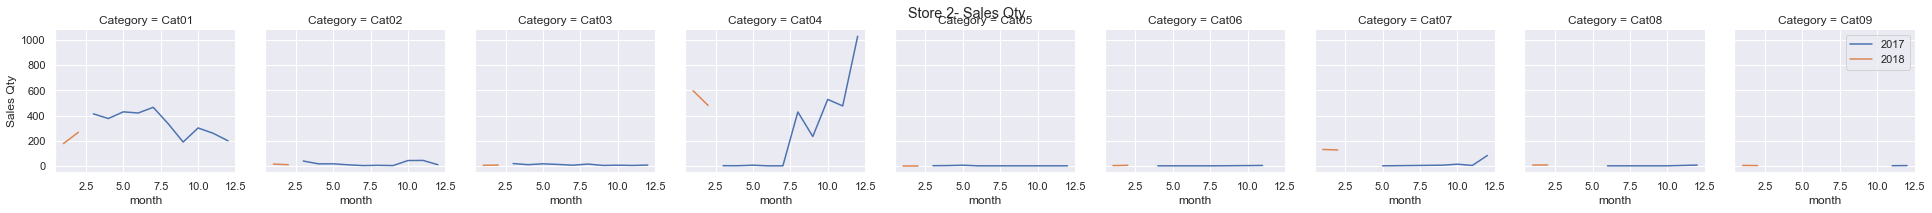

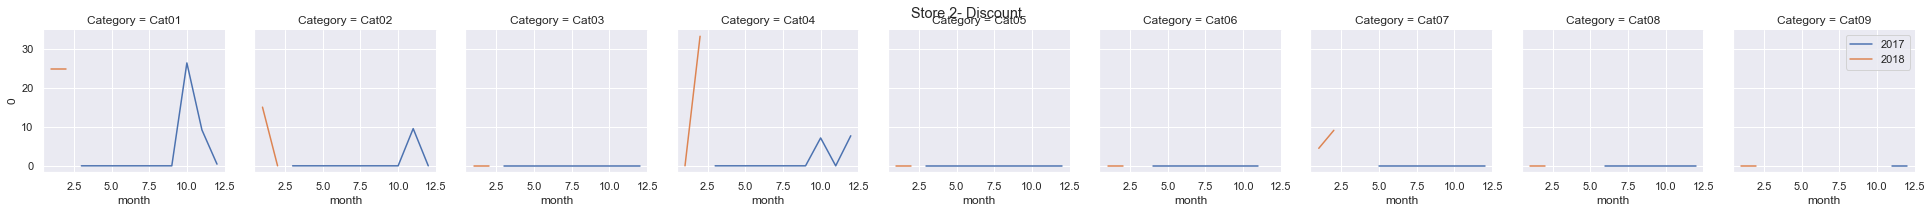

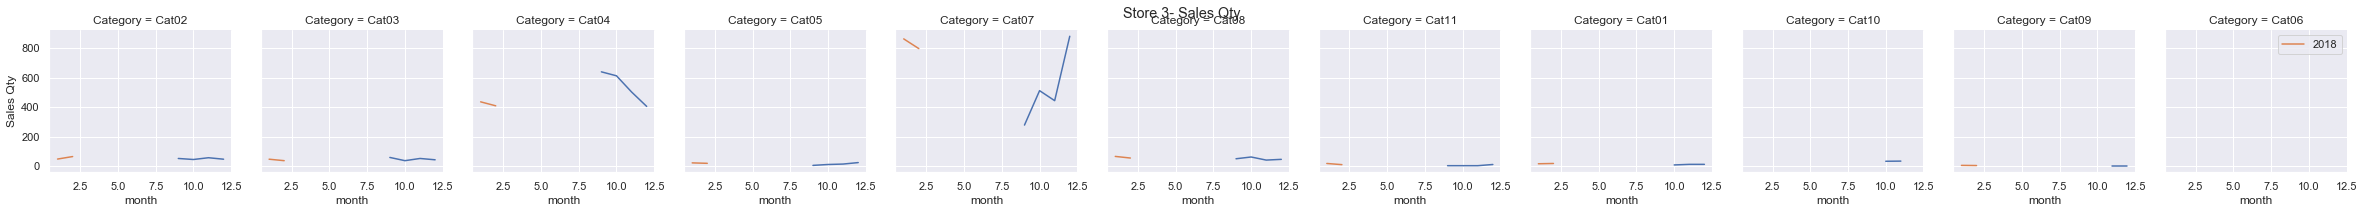

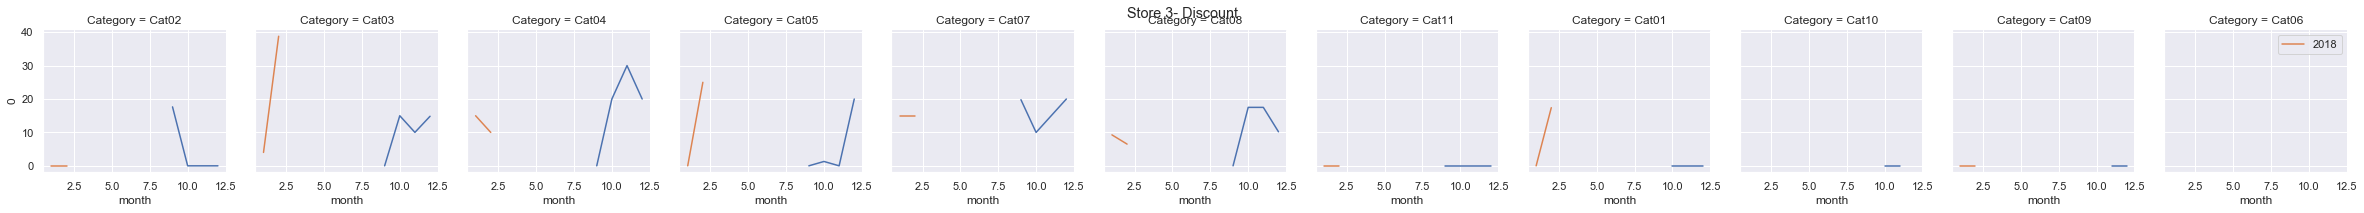

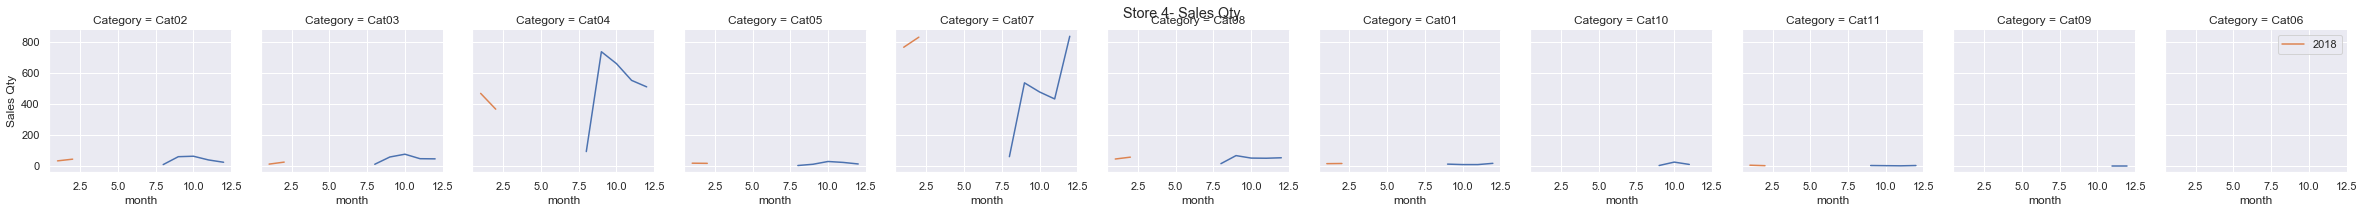

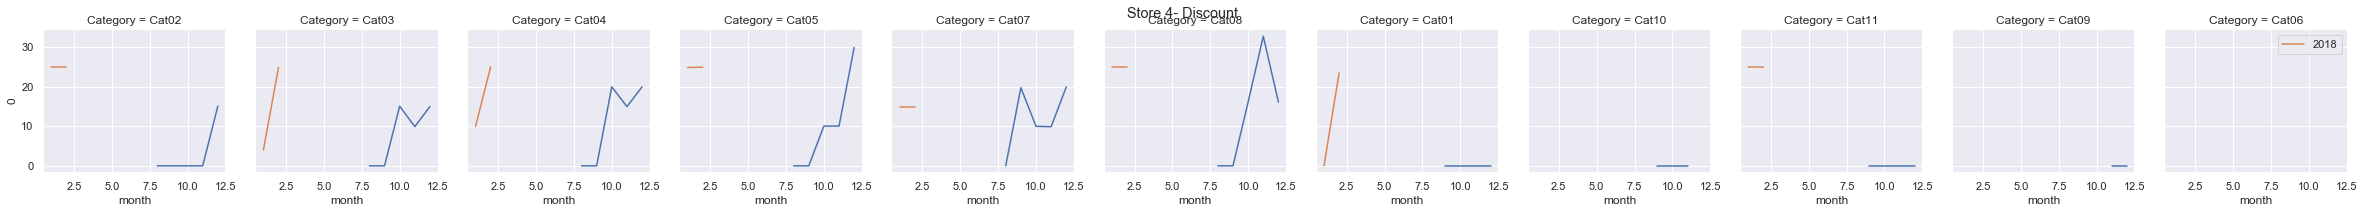

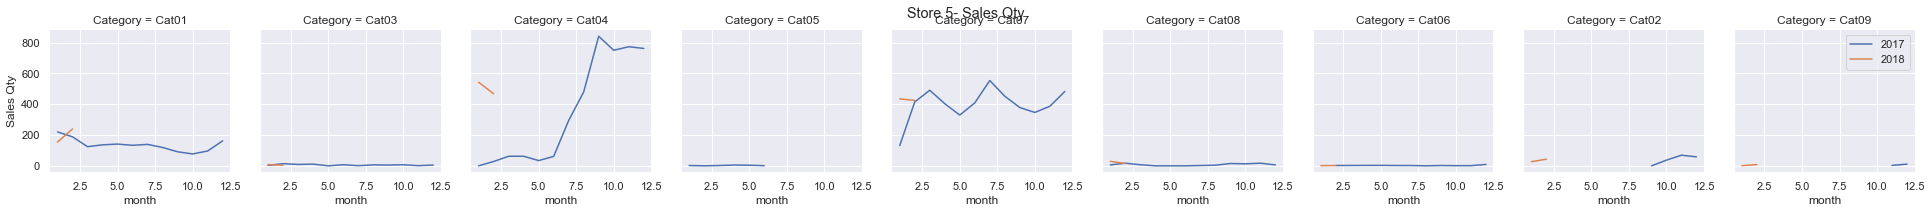

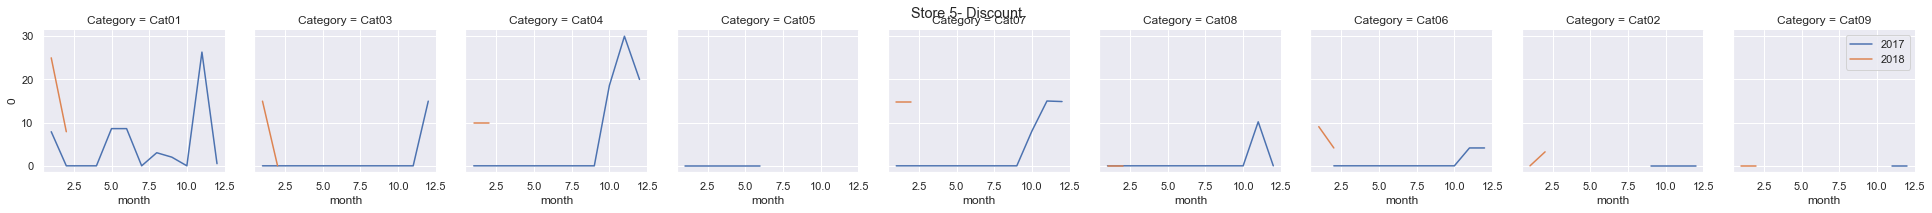

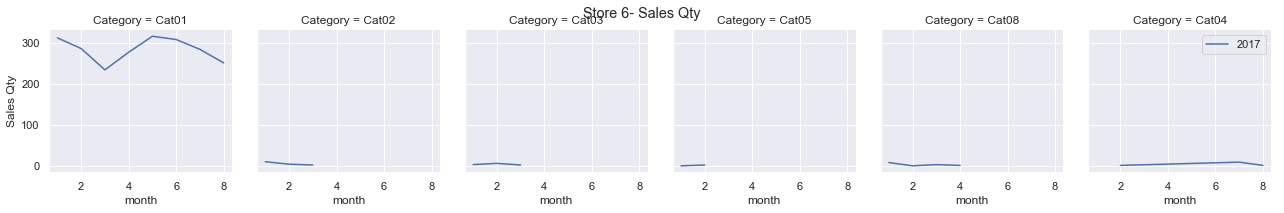

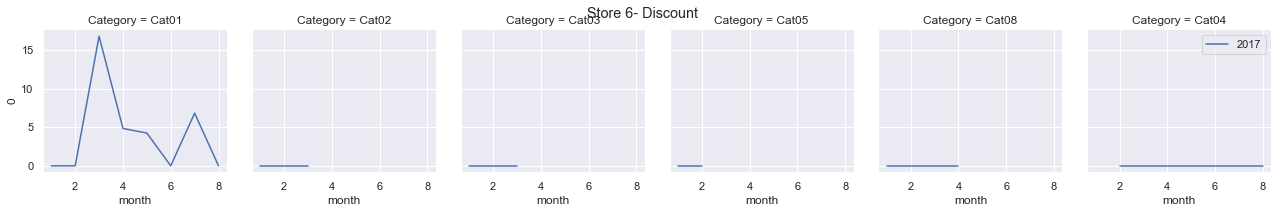

In [51]:
grouped = master_df.groupby(["Store Code"])

for store_code in stores:
    temp = grouped.get_group(store_code)
    frame = temp.groupby(["year", "month", "Category"])["Sales Qty"].sum().reset_index()

    if frame.shape[0] > 0:
        g = sns.FacetGrid(frame, col="Category", hue="year", margin_titles=True)
        g.map(plt.plot, "month", "Sales Qty")
        g.fig.suptitle(store_code + "- Sales Qty")
        
    plt.legend()
        
    frame = temp.groupby(["year", "month", "Category"]).apply(get_discount).reset_index()
 
    if frame.shape[0] > 0:
        g = sns.FacetGrid(frame, col="Category", hue="year", margin_titles=True)
        g.map(plt.plot, "month", 0)
        g.fig.suptitle(store_code + "- Discount")
    plt.legend()
        
    

#### Sales Qty & Discount by Category - Stores

D:\Anaconda\envs\py36\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


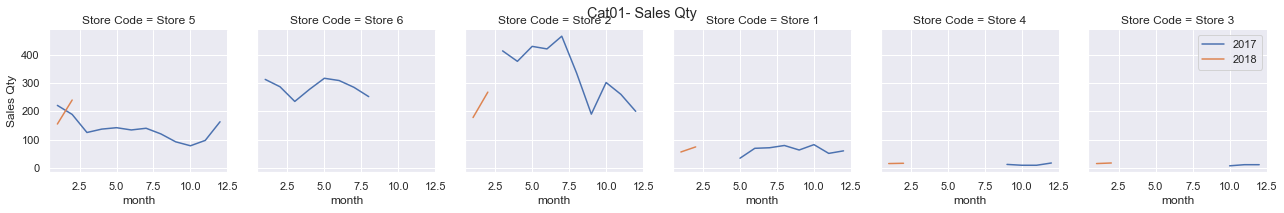

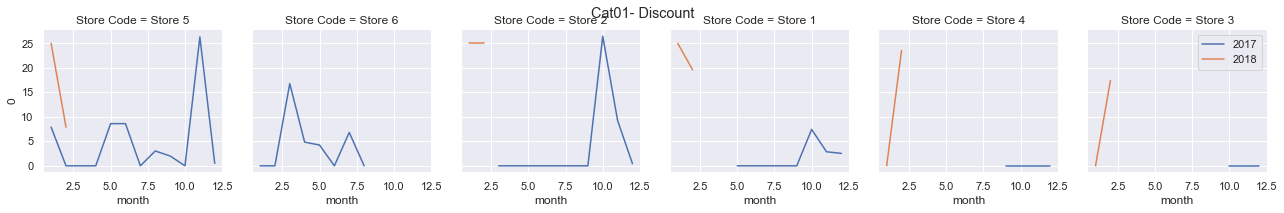

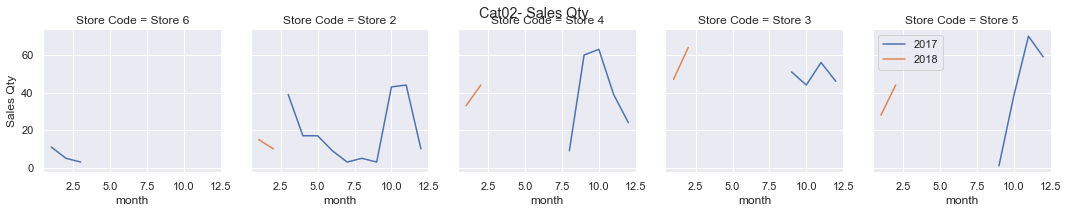

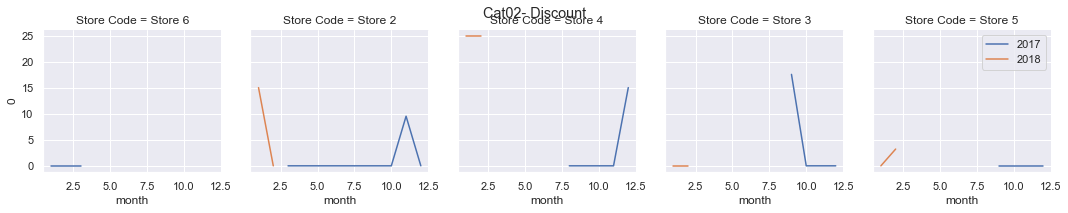

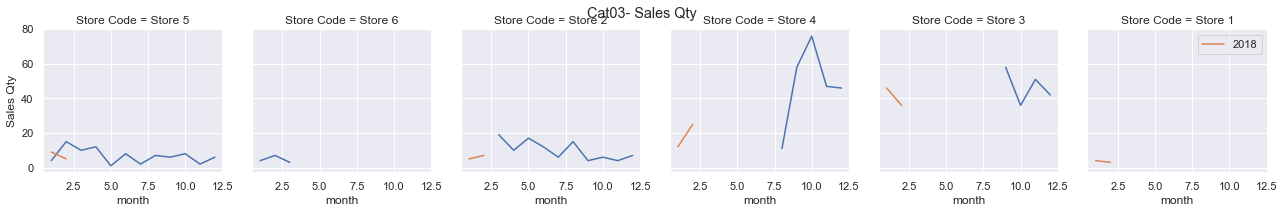

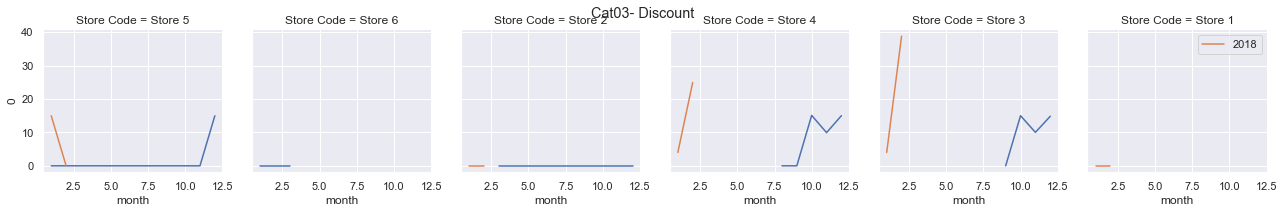

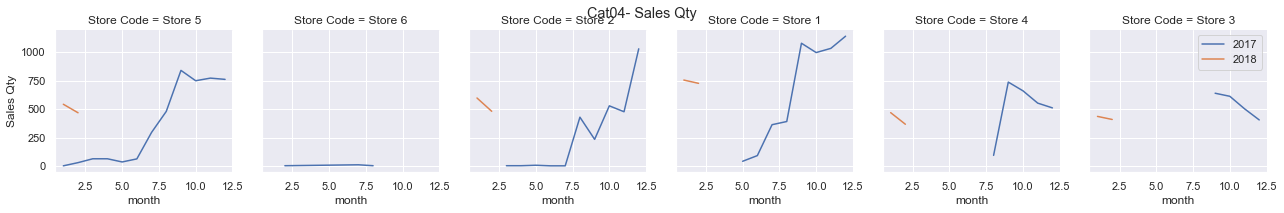

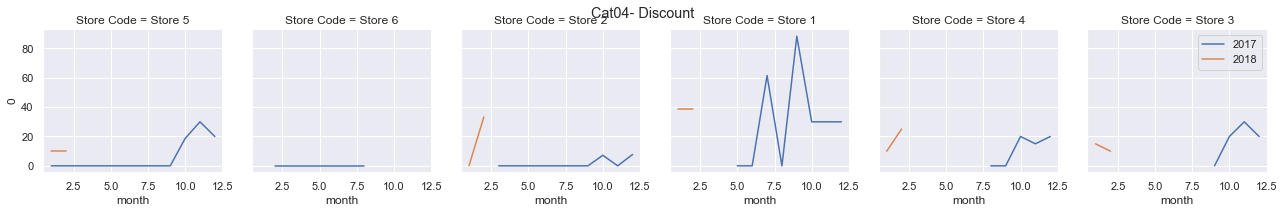

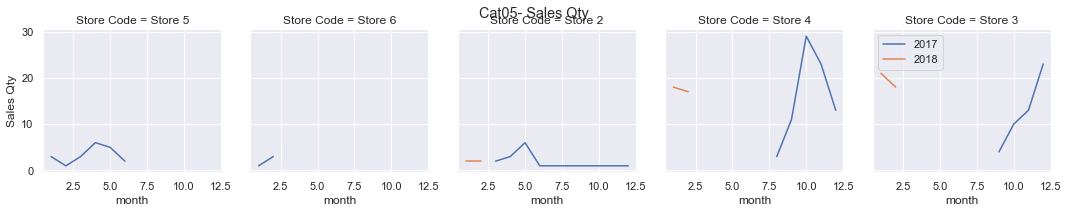

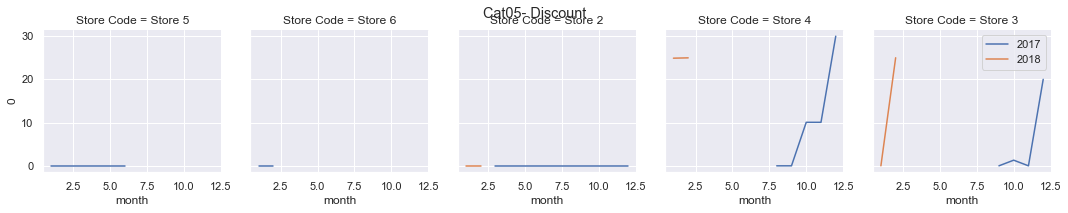

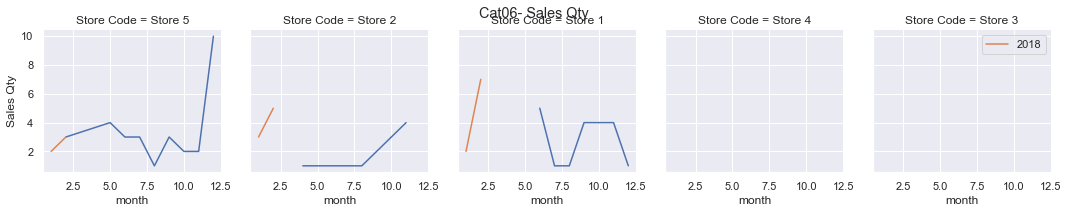

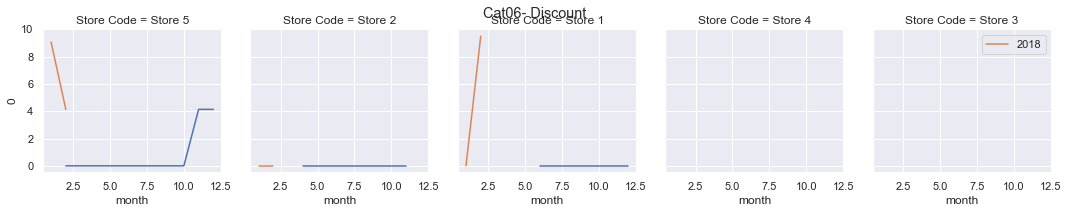

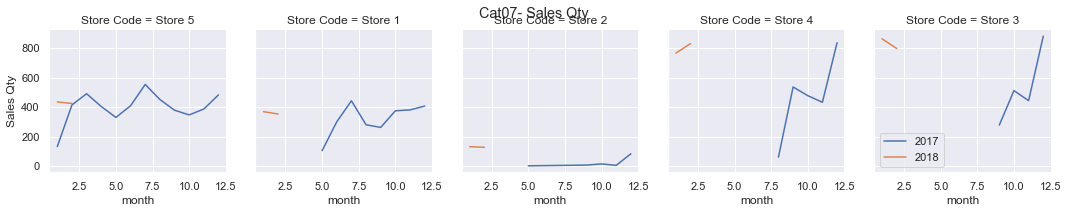

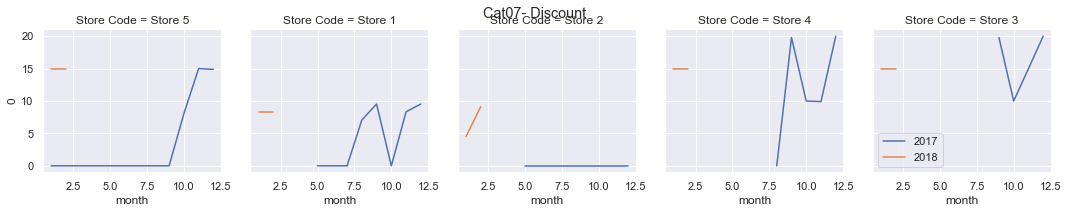

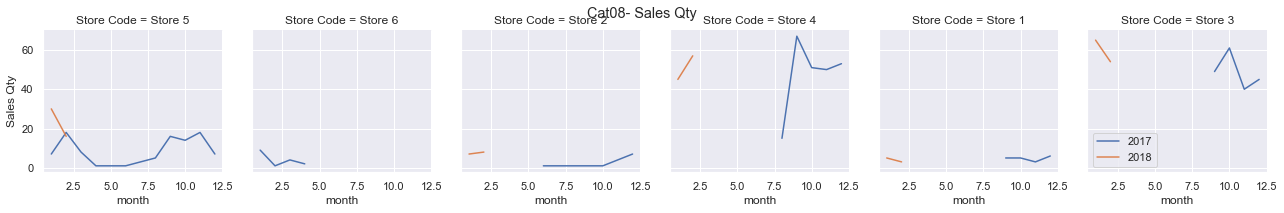

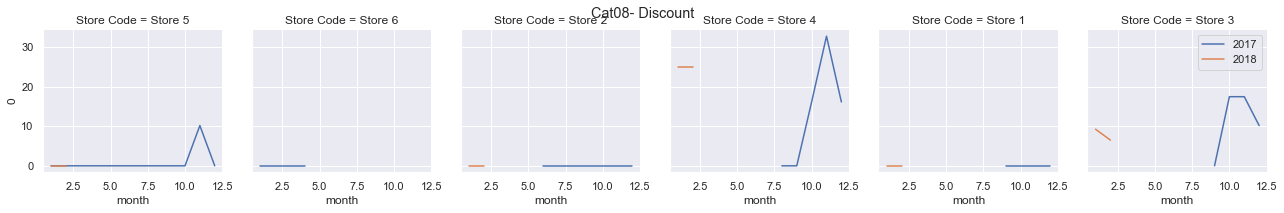

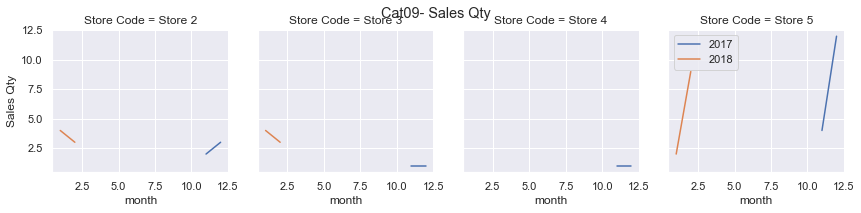

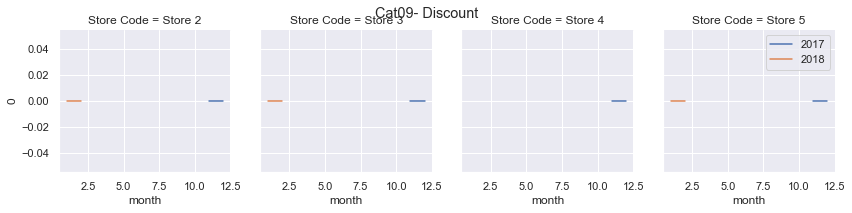

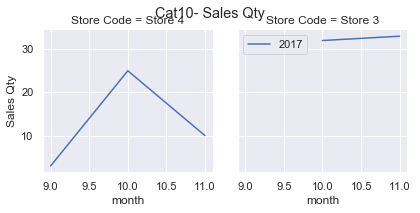

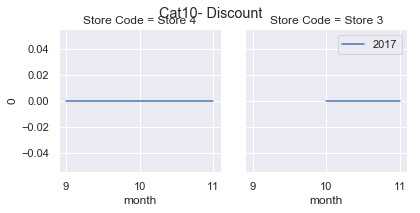

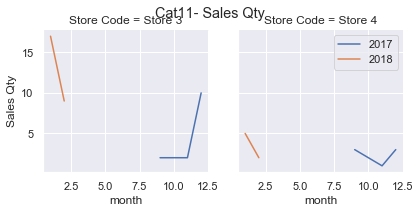

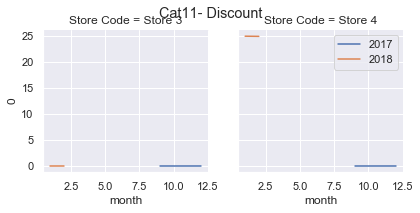

In [53]:
grouped = master_df.groupby(["Category"])

for category in categories:
    temp = grouped.get_group(category)
    frame = temp.groupby(["year", "month", "Store Code"])["Sales Qty"].sum().reset_index()

    if frame.shape[0] > 0:
        g = sns.FacetGrid(frame, col="Store Code", hue="year", margin_titles=True)
        g.map(plt.plot, "month", "Sales Qty")
        g.fig.suptitle(category + "- Sales Qty")
        
    plt.legend()
        
    frame = temp.groupby(["year", "month", "Store Code"]).apply(get_discount).reset_index()
 
    if frame.shape[0] > 0:
        g = sns.FacetGrid(frame, col="Store Code", hue="year", margin_titles=True)
        g.map(plt.plot, "month", 0)
        g.fig.suptitle(category + "- Discount")
    plt.legend()


#### Unique SUs by Category

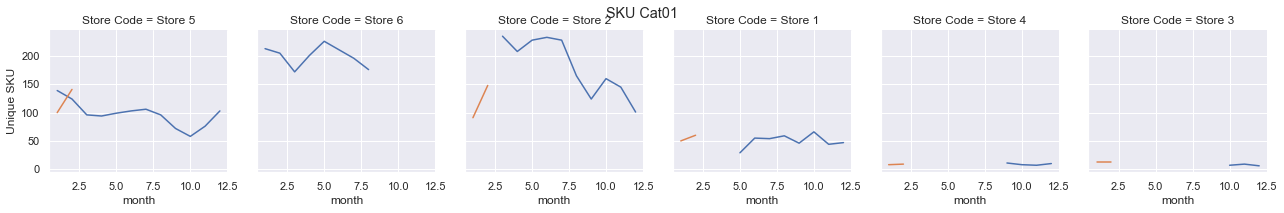

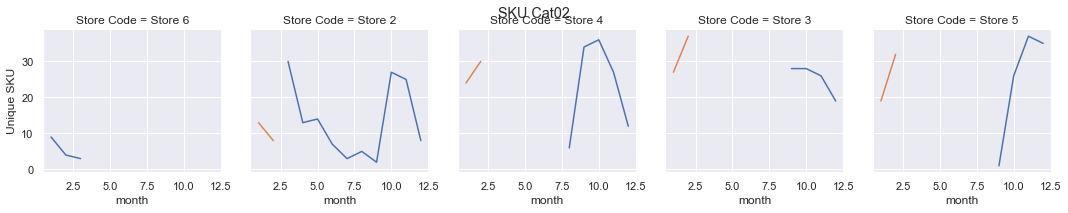

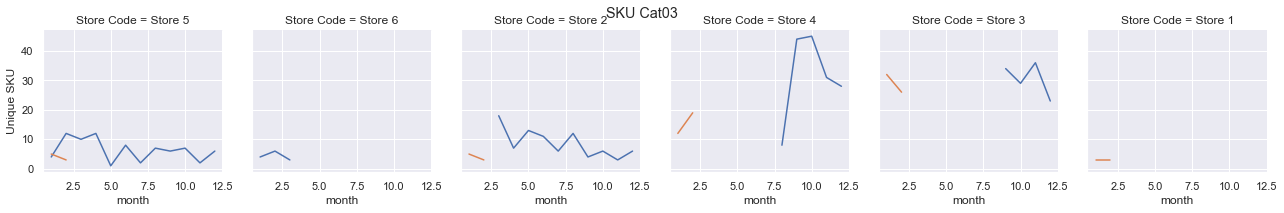

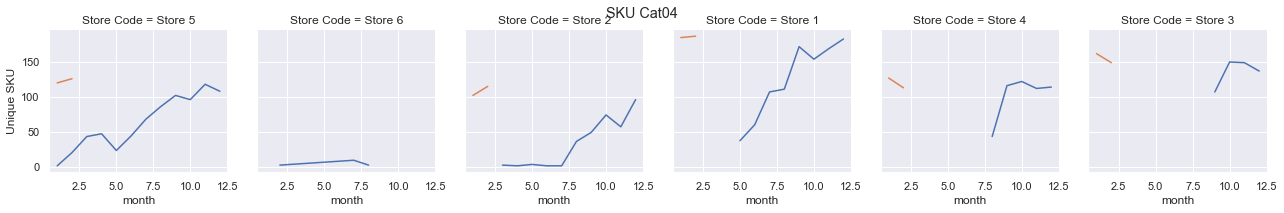

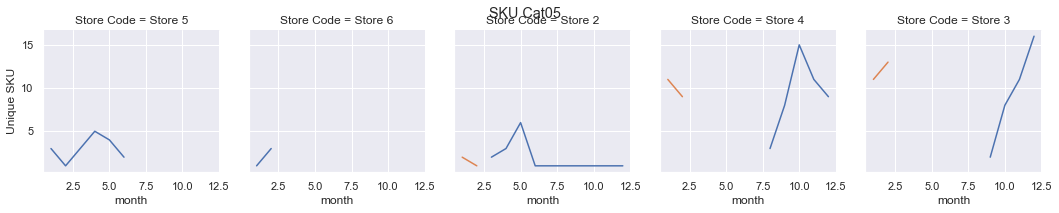

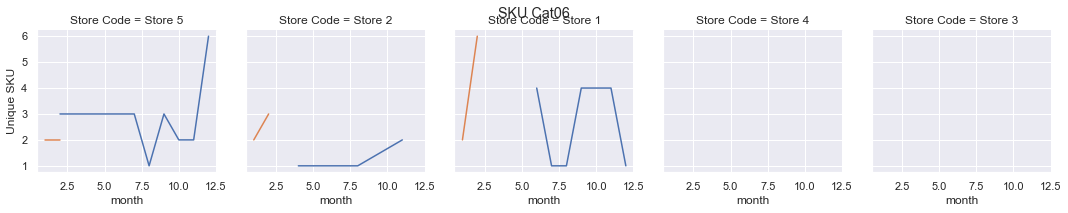

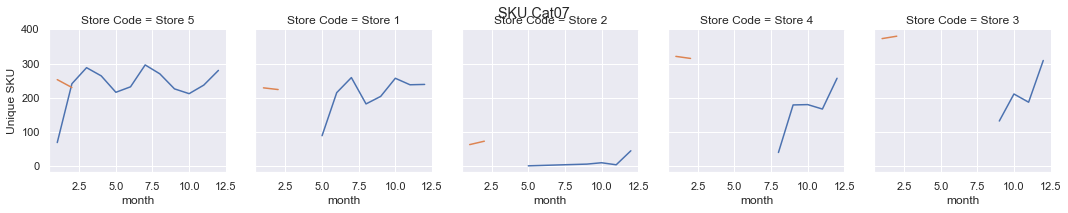

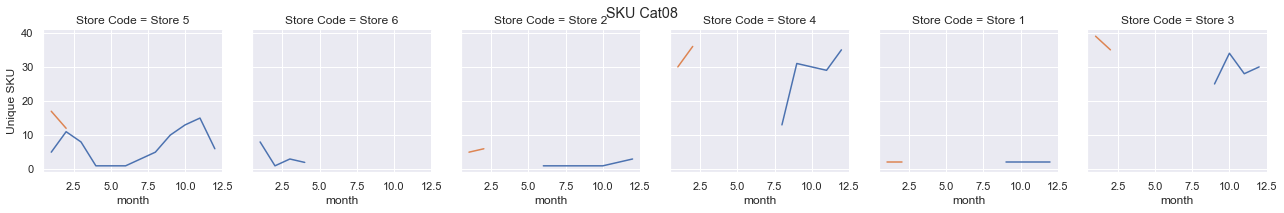

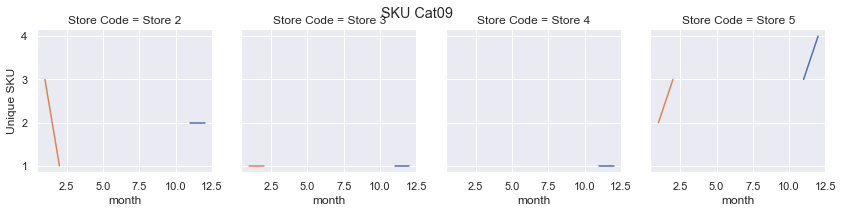

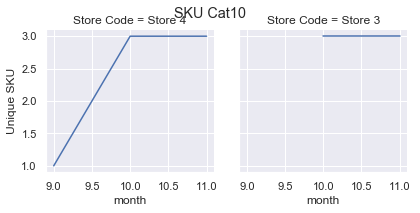

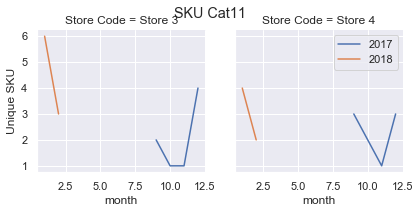

In [55]:
grouped = master_df.groupby(["Category"])

for category in categories:
    temp = grouped.get_group(category)
    frame = temp.groupby(["year", "month", "Store Code"])["SKU Code"].nunique().reset_index()
    frame.columns = ["year", "month", "Store Code", "Unique SKU"]

    if frame.shape[0] > 0:
        g = sns.FacetGrid(frame, col="Store Code", hue="year", margin_titles=True)
        g.map(plt.plot, "month", "Unique SKU")
        g.fig.suptitle("SKU " + category)

plt.legend()


#### Average Selling Price by Category

In [56]:
def get_average_selling_price(df):
    return sum(df["Amount"])/sum(df["Sales Qty"])

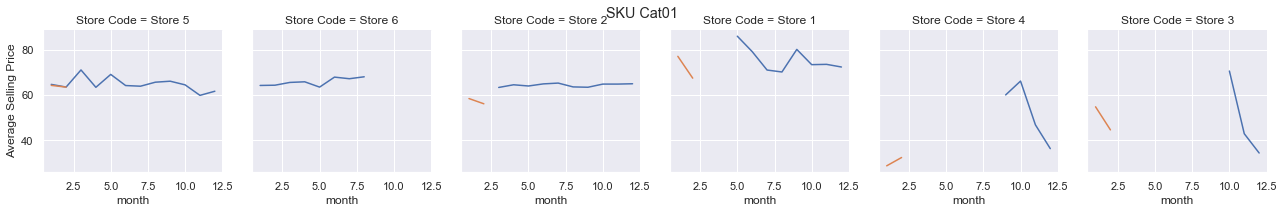

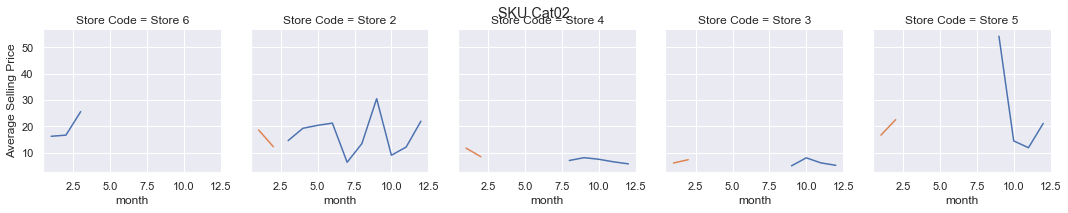

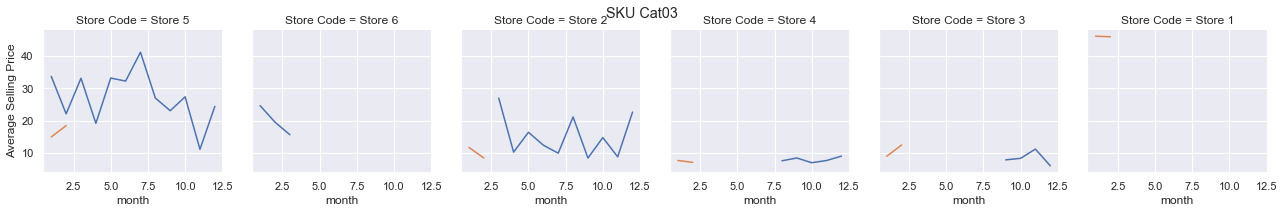

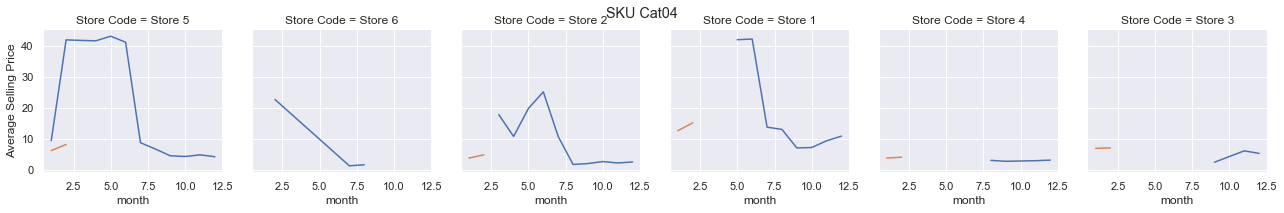

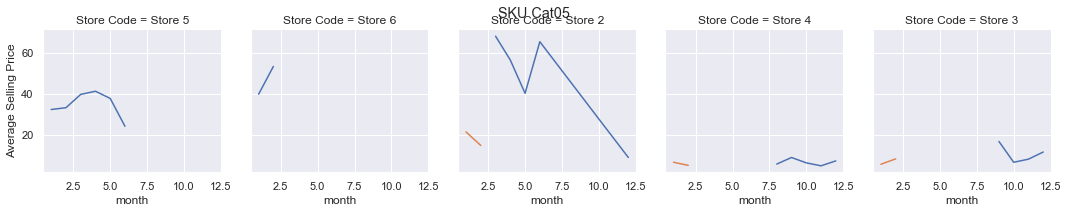

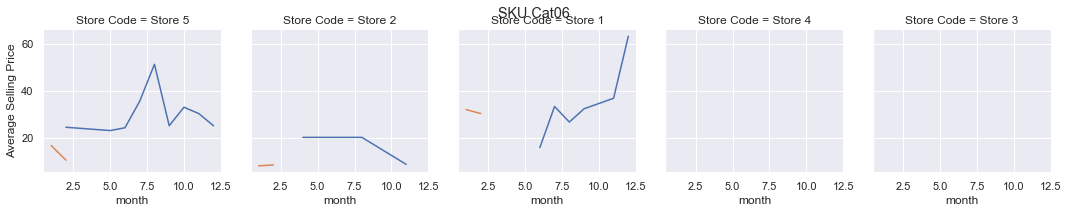

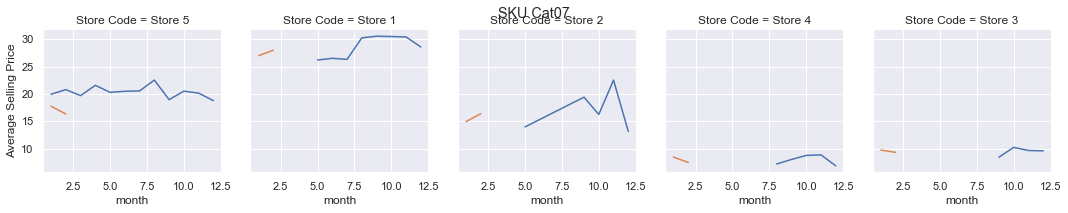

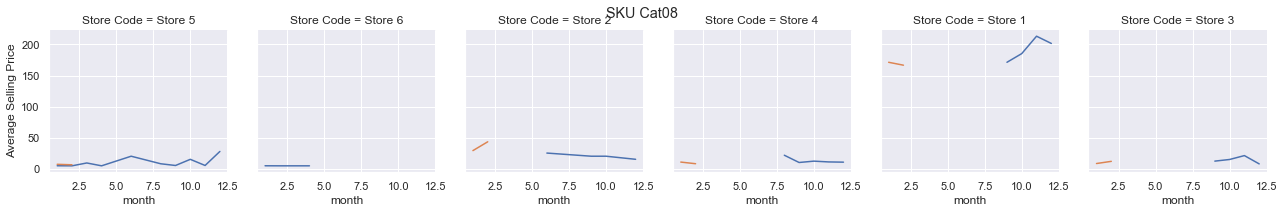

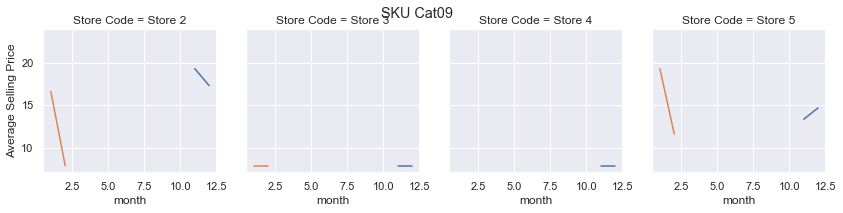

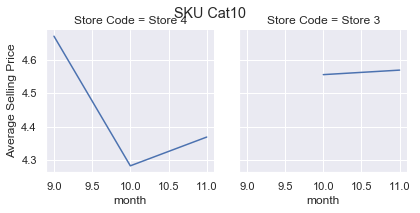

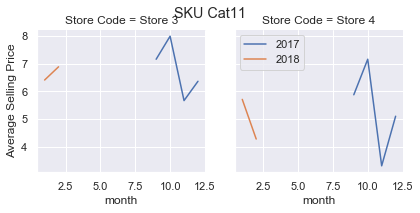

In [57]:
grouped = master_df.groupby(["Category"])

for category in categories:
    temp = grouped.get_group(category)
    frame = temp.groupby(["year", "month", "Store Code"]).apply(get_average_selling_price).reset_index()
    frame.columns = ["year", "month", "Store Code", "Average Selling Price"]

    if frame.shape[0] > 0:
        g = sns.FacetGrid(frame, col="Store Code", hue="year", margin_titles=True)
        g.map(plt.plot, "month", "Average Selling Price")
        g.fig.suptitle("SKU " + category)

plt.legend()